In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from talib.abstract import *
from sklearn.preprocessing import MinMaxScaler
import joblib
from finlab.data import Data

In [19]:
database = Data()
close = database.get("收盤價")
open_ = database.get("開盤價")
high = database.get("最高價")
low = database.get("最低價")
vol = database.get("成交股數")
accu = database.get("成交金額")
rev = database.get("當月營收")
com_rev = database.get("上月比較增減(%)")
d_yield = database.get("殖利率(%)")
pb = database.get("股價淨值比")

In [20]:
date = '2022=04-01'
start_date = '2020-01-01'
close = close[close.index > start_date]
open_ = open_[open_.index > start_date]
high = high[high.index > start_date]
low = low[low.index > start_date]
vol = vol[vol.index > start_date]
accu = accu[accu.index > start_date]
rev = rev[rev.index > start_date]
com_rev = com_rev[com_rev.index > start_date]
d_yield = d_yield[d_yield.index > start_date]
pb = pb[pb.index > start_date]

In [21]:
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

def MA(close, n):
    return close.rolling(window=n).mean()

def bias(close, n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(close, n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def mom(rev, n):
    return (rev / rev.shift(1)).shift(n)

# vol = vol.reset_index()
sid = '0050'
benchmark = pd.DataFrame({'close': close[sid], 'high': high[sid], 'low': low[sid], 'volume': vol[sid]})

benchmark['b_OBV'] = OBV(benchmark.close, benchmark.volume)
benchmark['b_AD'] = AD(benchmark.high, benchmark.low, benchmark.close, benchmark.volume)
benchmark['b_ADOSC'] = ADOSC(benchmark.high, benchmark.low, benchmark.close, benchmark.volume, fastperiod=3, slowperiod=10)

benchmark['b_MA5'] = MA(benchmark['close'], 5)
benchmark['b_MA20'] = MA(benchmark['close'], 20)
benchmark['b_MA60'] = MA(benchmark['close'], 60)

benchmark['b_bias5'] = bias(benchmark['close'], 5)
benchmark['b_bias10'] = bias(benchmark['close'], 10)
benchmark['b_bias20'] = bias(benchmark['close'], 20)
benchmark['b_bias60'] = bias(benchmark['close'], 60)

benchmark['b_acc5'] = acc(benchmark['close'], 5)
benchmark['b_acc10'] = acc(benchmark['close'], 10)
benchmark['b_acc20'] = acc(benchmark['close'], 20)
benchmark['b_acc60'] = acc(benchmark['close'], 60)

window_stdev = 50
benchmark['b_log_ret'] = np.log(benchmark['close']).diff()
benchmark['b_volatility'] = benchmark['b_log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

In [22]:
benchmark.tail()

,close,high,low,volume,b_OBV,b_AD,b_ADOSC,b_MA5,b_MA20,b_MA60,b_bias5,b_bias10,b_bias20,b_bias60,b_acc5,b_acc10,b_acc20,b_acc60,b_log_ret,b_volatility
date,,,,,,,,,,,,,,,,,,,,
2022-03-28,136.70,137.00,135.55,11194840.0,-89352317.0,2.276878e+08,6.321398e+04,137.56,136.1225,142.133333,0.993748,1.004298,1.004243,0.961773,1.010697,0.976744,0.971248,1.025298,-0.010913,0.013656
2022-03-29,136.85,137.20,136.60,6644012.0,-82708305.0,2.265804e+08,9.832240e+05,137.57,135.9425,142.050000,0.994766,1.001574,1.006676,0.963393,1.018994,0.949513,0.982340,1.028457,0.001097,0.013617
2022-03-30,138.55,138.70,138.05,8498372.0,-74209933.0,2.311565e+08,2.726223e+06,137.66,135.8875,141.981667,1.006465,1.009325,1.019593,0.975830,1.020129,0.950395,0.993243,1.039155,0.012346,0.013715
2022-03-31,138.10,138.65,138.10,3748776.0,-77958709.0,2.274077e+08,1.998637e+06,137.68,135.7950,141.899167,1.003051,1.004802,1.016974,0.973226,1.005464,0.981119,0.992201,1.039796,-0.003253,0.013674
2022-04-01,136.95,136.95,136.15,8220571.0,-86179280.0,2.356283e+08,4.134930e+06,137.43,135.7200,141.779167,0.996507,0.995819,1.009063,0.965939,1.012269,0.988381,0.993898,1.064230,-0.008362,0.013678


In [34]:
sid = '2330'
t_final = 5
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

def get_atr(stock, win=14):
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(data.high.rolling( \
                        win, min_periods=win))
    low = pd.Series(data.low.rolling( \
                    win, min_periods=win))
    close = pd.Series(data.close.rolling( \
                        win, min_periods=win))    
            
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                    np.abs(high[i] - close[i]), \
                    np.abs(low[i] - close[i])], \
                    axis=0)
    atr_df[i] = tr.sum() / win
        
    return  atr_df

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier', 'long_ret', 'short_ret'], \
            index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                    [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                        upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                        upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)

        barriers.loc[day, ['days_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
        days_passed, prices.loc[day], vert_barrier, \
        top_barrier, bottom_barrier
    return barriers

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
            top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
            bottom_barrier).any()
            #assign the labels 如果True情況下不設out為2會產生touch vertical bar 時產生 > 1 的值
            if condition_pt:  # over the top_barrier
                barriers['out'][i] = 1
            elif condition_sl:  # below the bottom_barrier
                # barriers['out'][i] = 0
                barriers['out'][i] = -1    
            else: 
                barriers['out'][i] = 0 # vertical_barrier
                # barriers['out'][i] = max(
                #           [(price_final - price_initial)/ 
                #            (top_barrier - price_initial), \
                #            (price_final - price_initial)/ \
                #            (price_initial - bottom_barrier)],\
                #             key=abs)
            if condition_pt:  # over the top_barrier
                barriers['long_ret'][i] = (top_barrier - price_initial)/price_initial - 0.001
                barriers['short_ret'][i] = -(top_barrier - price_initial)/price_initial - 0.001
            elif condition_sl:  # below the bottom_barrier
                barriers['long_ret'][i] = -(price_initial - bottom_barrier)/price_initial - 0.001
                barriers['short_ret'][i] = (price_initial - bottom_barrier)/price_initial - 0.001
            else: 
                barriers['long_ret'][i] = (price_final - price_initial)/price_initial - 0.001
                barriers['short_ret'][i] = -(price_final - price_initial)/price_initial - 0.001
    return

data = pd.DataFrame({'close': close[sid],
                    'open': open_[sid],
                    'high': high[sid],
                    'low': low[sid],
                    'volume': vol[sid]})

data = data.reset_index()
data.dropna(axis=0, how='any', inplace=True)
rev = rev.reset_index()
# print(f'shape of df {data.shape}')
data = pd.merge(data,rev[['date',sid]], on="date", how='outer')
# print(f'shape of df {data.shape}')
data = data.sort_values(by=['date'])
data = data.rename(columns={sid: "rev"})
data['rev'].fillna(method='ffill', inplace=True)

com_rev = com_rev.reset_index()
# print(f'shape of df {data.shape}')
data = pd.merge(data,com_rev[['date',sid]], on="date", how='outer')
# print(f'shape of df {data.shape}')
data = data.sort_values(by=['date'])
data = data.rename(columns={sid: "com_rev"})
data['com_rev'].fillna(method='ffill', inplace=True)

d_yield = d_yield.reset_index()
# print(f'shape of df {data.shape}')
data = pd.merge(data,d_yield[['date',sid]], on="date", how='outer')
# print(f'shape of df {data.shape}')
data = data.rename(columns={sid: "d_yield"})
data['d_yield'].fillna(method='ffill', inplace=True)

pb = pb.reset_index()
# print(f'shape of df {data.shape}')
data = pd.merge(data,pb[['date',sid]], on="date", how='outer')
# print(f'shape of df {data.shape}')
data = data.rename(columns={sid: "pb"})
data['pb'].fillna(method='ffill', inplace=True)

benchmark = benchmark.reset_index()
benchmark_list = ['date', 'b_OBV', 'b_AD', 'b_ADOSC', 'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60'
, 'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility']
data = pd.merge(data,benchmark[benchmark_list], on="date", how='outer')
for features in benchmark_list:
    data[features].fillna(method='ffill', inplace=True)

data = data.set_index('date')
# print(f'shape of df {data.shape}')
data.dropna(axis=0, how='any', inplace=True)
# print(f'shape of df {data.shape}')
# data.tail()

# talib
# data.to_csv('test.csv', index=False)
data['upperband'], data['middleband'], data['lowerband'] = BBANDS(data.close, 20, 2., 2. ,0)
data['OBV'] = OBV(data.close, data.volume)
data['AD'] = AD(data.high, data.low, data.close, data.volume)
data['ADOSC'] = ADOSC(data.high, data.low, data.close, data.volume, fastperiod=3, slowperiod=10)

data['MA5'] = MA(data['close'], 5)
data['MA60'] = MA(data['close'], 60)

data['bias5'] = bias(data['close'], 5)
data['bias10'] = bias(data['close'], 10)
data['bias20'] = bias(data['close'], 20)
data['bias60'] = bias(data['close'], 60)

data['acc5'] = acc(data['close'], 5)
data['acc10'] = acc(data['close'], 10)
data['acc20'] = acc(data['close'], 20)
data['acc60'] = acc(data['close'], 60)

rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)
# Compute sides
data['side'] = np.nan 
data['cs1'] = data['close'].shift(1)
data['vol1'] = data['volume'].shift(1)

# long_signals = (data['close'] >= data['upperband']) & (data['cs1'] <= data['upperband']) & (data['volume'] > data['vol1']) & (data['close'] > data['open'])
# short_signals = (data['close'] <= data['lowerband']) & (data['cs1'] >= data['lowerband']) & (data['volume'] > data['vol1']) & (data['open'] > data['close'])
short_signals = data['close'] >= data['upperband']
long_signals = data['close'] <= data['lowerband']

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

data['side'].fillna(value=0, inplace=True)
# raw_data = data.copy()

# Log Returns
data['log_ret'] = np.log(data['close']).diff()
# Momentum
data['mom1'] = data['close'].pct_change(periods=1)
data['mom2'] = data['close'].pct_change(periods=2)
data['mom3'] = data['close'].pct_change(periods=3)
data['mom4'] = data['close'].pct_change(periods=4)
data['mom5'] = data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
data['volatility'] = data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

data['autocorr_1'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
data['autocorr_2'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
data['autocorr_3'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
data['autocorr_4'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
data['autocorr_5'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
data['log_t1'] = data['log_ret'].shift(1)
data['log_t2'] = data['log_ret'].shift(2)
data['log_t3'] = data['log_ret'].shift(3)
data['log_t4'] = data['log_ret'].shift(4)
data['log_t5'] = data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

data['sma'] = np.nan


In [35]:
long_signals = data['fast_mavg'] >= data['slow_mavg']
short_signals = data['fast_mavg'] < data['slow_mavg']
data.loc[long_signals, 'sma'] = 1
data.loc[short_signals, 'sma'] = -1
data['sma'].fillna(value=0, inplace=True)

price = data['close']
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
prices = price[daily_volatility.index]
barriers = get_3_barriers()
barriers['out'] = None
get_labels()
data = data.reset_index()
barriers = barriers.reset_index()
data = pd.merge(data,barriers[['date','out','long_ret', 'short_ret', 'top_barrier', 'bottom_barrier']], on="date", how="outer")
# data.dropna(axis=0, how='any', inplace=True)
data = data.reset_index()

data['next_close'] = data['close'].shift(-1)
data['diff'] = (data['next_close'] - data['close'])/data['close']

# training_data
# normalize
feature_list = ['com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
    'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
    'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
    'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
    'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_OBV', 'b_AD', 'b_ADOSC',
    'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60',
    'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility']

scale = MinMaxScaler(feature_range = (-1, 1)) #z-scaler物件
for item in feature_list:
    data[item] = scale.fit_transform(np.array(data[item].to_list()).reshape(-1, 1))

data.dropna(axis=0, how='any', inplace=True)

In [36]:
data.tail()

,index,date,close,open,high,low,volume,rev,com_rev,d_yield,...,fast_mavg,slow_mavg,sma,out,long_ret,short_ret,top_barrier,bottom_barrier,next_close,diff
410,410,2022-03-11,575.0,581.0,582.0,574.0,42981381.0,146933238.0,-0.940286,-0.604790,...,580.857143,600.000000,-1.0,1,0.03599,-0.03799,596.269,553.731,572.0,-0.005217
411,411,2022-03-14,572.0,574.0,577.0,572.0,38562552.0,146933238.0,-0.940286,-0.592814,...,576.571429,595.666667,-1.0,1,0.0341861,-0.0361861,592.126,551.874,558.0,-0.024476
412,412,2022-03-15,558.0,562.0,563.0,558.0,84338792.0,146933238.0,-0.940286,-0.544910,...,571.285714,590.733333,-1.0,1,0.0345208,-0.0365208,577.821,538.179,558.0,0.000000
413,413,2022-03-16,558.0,564.0,565.0,555.0,50764807.0,146933238.0,-0.940286,-0.544910,...,568.714286,586.133333,-1.0,1,0.0330203,-0.0350203,576.983,539.017,582.0,0.043011
414,414,2022-03-17,582.0,578.0,583.0,575.0,65820899.0,146933238.0,-0.940286,-0.628743,...,571.428571,583.266667,-1.0,0,0.0110275,-0.0130275,607.487,556.513,581.0,-0.001718


<AxesSubplot:>

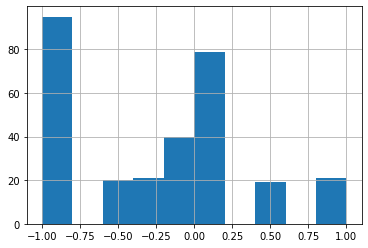

In [37]:
data.com_rev.hist()

In [38]:
mrl_m = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\mr_long_BernoulliNB_0419.pkl')
mrs_m = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\mr_short_LGBM_0419.pkl')
tl_m = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\trend_long_LGBM_0419.pkl')
ts_m = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\trend_short_LGBM_0419.pkl')

In [39]:
X = data[feature_list]
model_dict = {'mrl_m':mrl_m, 'mrs_m':mrs_m, 'tl_m':tl_m, 'ts_m':ts_m}
for key in model_dict:
    # make predictions for test data
    y_pred = model_dict[key].predict(X)
    data[key] = y_pred

data['lowerbond_decision'] = [-1 if (x == 0) & (y == 1) else 1 for x,y in zip(data['mrl_m'], data['ts_m'])]
data['upperbond_decision'] = [-1 if (x == 1) & (y == 0) else 1 for x,y in zip(data['mrs_m'], data['tl_m'])]

In [56]:
data = data.set_index('date')

In [55]:
data.tail()

,index,date,close,open,high,low,volume,rev,com_rev,d_yield,...,top_barrier,bottom_barrier,next_close,diff,mrl_m,mrs_m,tl_m,ts_m,lowerbond_decision,upperbond_decision
410,410,2022-03-11,575.0,581.0,582.0,574.0,42981381.0,146933238.0,-0.940286,-0.604790,...,596.269,553.731,572.0,-0.005217,1,0,0,0,1,1
411,411,2022-03-14,572.0,574.0,577.0,572.0,38562552.0,146933238.0,-0.940286,-0.592814,...,592.126,551.874,558.0,-0.024476,1,0,0,0,1,1
412,412,2022-03-15,558.0,562.0,563.0,558.0,84338792.0,146933238.0,-0.940286,-0.544910,...,577.821,538.179,558.0,0.000000,1,0,0,0,1,1
413,413,2022-03-16,558.0,564.0,565.0,555.0,50764807.0,146933238.0,-0.940286,-0.544910,...,576.983,539.017,582.0,0.043011,1,0,0,0,1,1
414,414,2022-03-17,582.0,578.0,583.0,575.0,65820899.0,146933238.0,-0.940286,-0.628743,...,607.487,556.513,581.0,-0.001718,1,0,0,0,1,1


In [53]:
import pyfolio as pf

In [54]:
perf_func = pf.timeseries.perf_stats

In [57]:
data.columns

Index(['index', 'close', 'open', 'high', 'low', 'volume', 'rev', 'com_rev',
       'd_yield', 'pb', 'b_OBV', 'b_AD', 'b_ADOSC', 'b_MA5', 'b_MA20',
       'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60', 'b_acc5',
       'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility', 'upperband',
       'middleband', 'lowerband', 'OBV', 'AD', 'ADOSC', 'MA5', 'MA60', 'bias5',
       'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
       'side', 'cs1', 'vol1', 'log_ret', 'mom1', 'mom2', 'mom3', 'mom4',
       'mom5', 'volatility', 'autocorr_1', 'autocorr_2', 'autocorr_3',
       'autocorr_4', 'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4',
       'log_t5', 'fast_mavg', 'slow_mavg', 'sma', 'out', 'long_ret',
       'short_ret', 'top_barrier', 'bottom_barrier', 'next_close', 'diff',
       'mrl_m', 'mrs_m', 'tl_m', 'ts_m', 'lowerbond_decision',
       'upperbond_decision'],
      dtype='object')

In [65]:
df = data[(data.side == 1)&(data.lowerbond_decision == 1)][['side', 'lowerbond_decision', 'upperbond_decision', 'long_ret', 'short_ret']]
df.head()

,side,lowerbond_decision,upperbond_decision,long_ret,short_ret
date,,,,,
2021-03-24,1.0,1,1,0.0330541,-0.0350541
2021-03-25,1.0,1,1,0.0314407,-0.0334407
2021-05-03,1.0,1,1,-0.0272444,0.0252444
2021-05-11,1.0,1,1,-0.0321125,0.0301125
2021-05-12,1.0,1,1,0.0299597,-0.0319597


In [64]:
df.short_ret.sum()

-0.0673357899191838

In [ ]:
test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
# base_rets = labels['ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)

In [52]:
result_df = data[['side', 'mrl_m', 'mrs_m', 'tl_m', 'ts_m']].loc[date]
result_df['sid'] = sid
result_df

side        0
mrl_m       0
mrs_m       0
tl_m        1
ts_m        0
sid      2330
Name: 2022-04-01 00:00:00, dtype: object

In [58]:
result_df.to_frame().T

,side,mrl_m,mrs_m,tl_m,ts_m,sid
2022-04-01,0,0,0,1,0,2330
